<a href="https://colab.research.google.com/github/madhavjk/Time_series-projects/blob/main/AirPassenger/Passenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEPS:


1.   EDA
2.   Decomposition of data 

1.   Stationarity Check
2.   Fit a Model using an ARIMA algorithm

1.   Calculate forecasts 














In [5]:
!pip install statsmodels

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('AirPassengers.csv')

In [8]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [10]:
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]),15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [11]:
ts = data['#Passengers']

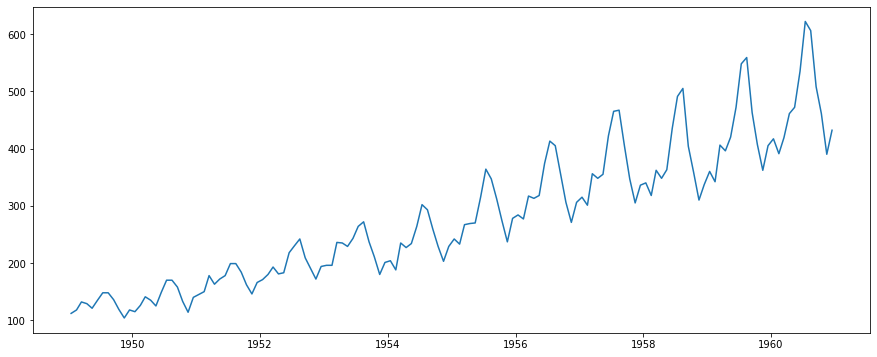

In [12]:
plt.plot(ts)

In [13]:
ts_log = np.log(ts)

In [31]:
ts_log

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
                ...   
1960-08-15    6.406880
1960-09-15    6.230481
1960-10-15    6.133398
1960-11-15    5.966147
1960-12-15    6.068426
Name: #Passengers, Length: 144, dtype: float64

**Dickey-Fuller Test**

In [14]:
def test_stationarity(timeseries):
  rolmean = timeseries.rolling(window=52,center=False).mean()
  rolstd = timeseries.rolling(window=52,center=False).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='Rolling Mean')
  std = plt.plot(rolstd,color='black',label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries,autolag='AIC')
  print(pd.Series(dftest))
  
  
  dfoutput = pd.Series(dftest[0:4],index =['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)   

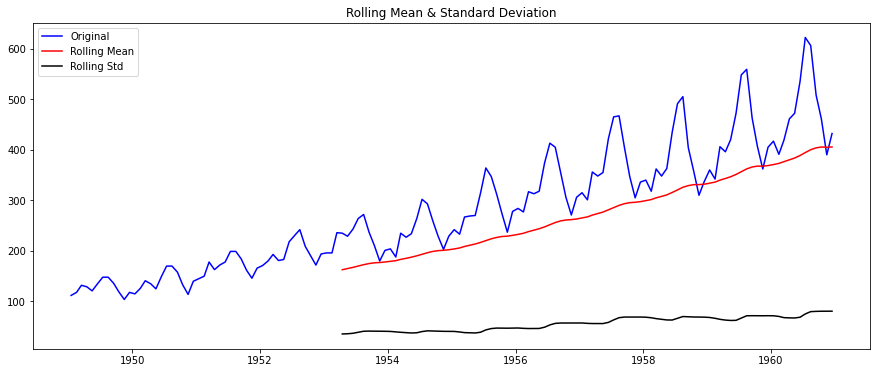

Results of Dickey-Fuller Test:
0                                             0.815369
1                                              0.99188
2                                                   13
3                                                  130
4    {'1%': -3.4816817173418295, '5%': -2.884041834...
5                                              996.693
dtype: object
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:


test_stationarity(data['#Passengers'])

***Test Statistic is  greater than Critical Value, and moving avg are cnto constant over time, so null hypothesis can't be rejected.This shows time series isn't stationary.***

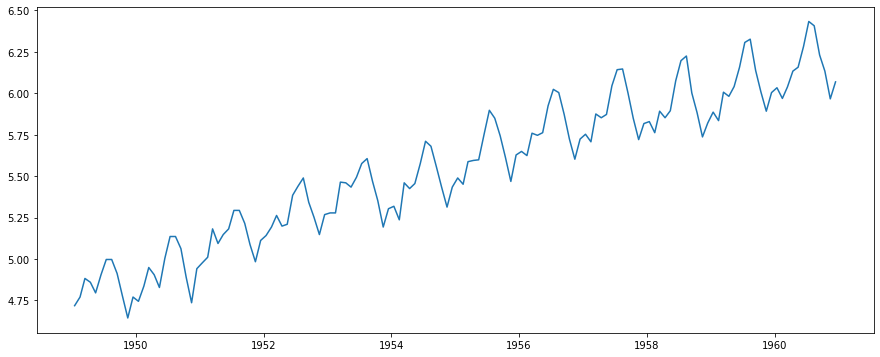

In [16]:
plt.plot(ts_log)

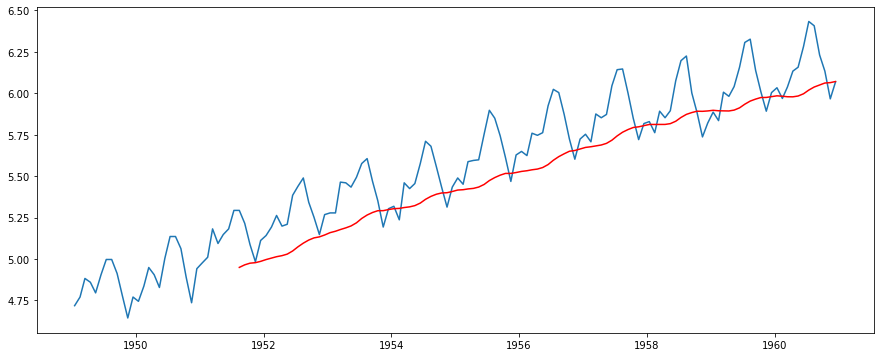

In [17]:
movingAverage = ts_log.rolling(window=32).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [18]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1951-08-15    0.343842
1951-09-15    0.249959
1951-10-15    0.112716
1951-11-15    0.005576
1951-12-15    0.126077
1952-01-15    0.144944
1952-02-15    0.187247
1952-03-15    0.248684
1952-04-15    0.178201
1952-05-15    0.179914
Name: #Passengers, dtype: float64

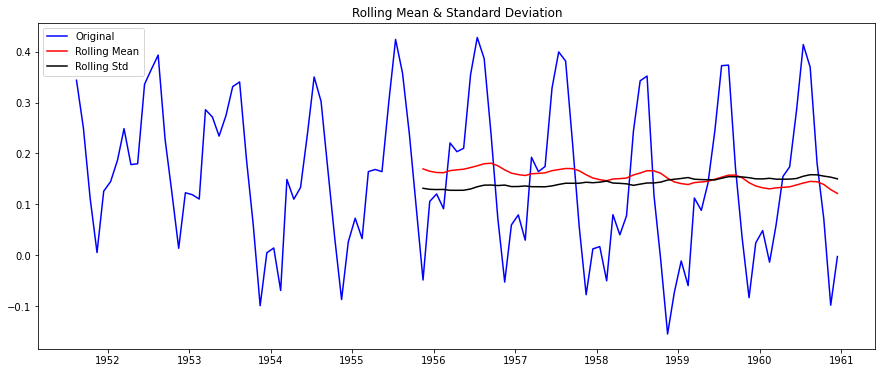

Results of Dickey-Fuller Test:
0                                             -2.45245
1                                             0.127475
2                                                   13
3                                                   99
4    {'1%': -3.498198082189098, '5%': -2.8912082118...
5                                             -364.805
dtype: object
Test Statistic                 -2.452454
p-value                         0.127475
#Lags Used                     13.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [19]:
test_stationarity(ts_log_mv_diff)

***We can reject null hypothesis, timeseries is stationary.***

**ACF CURVE**

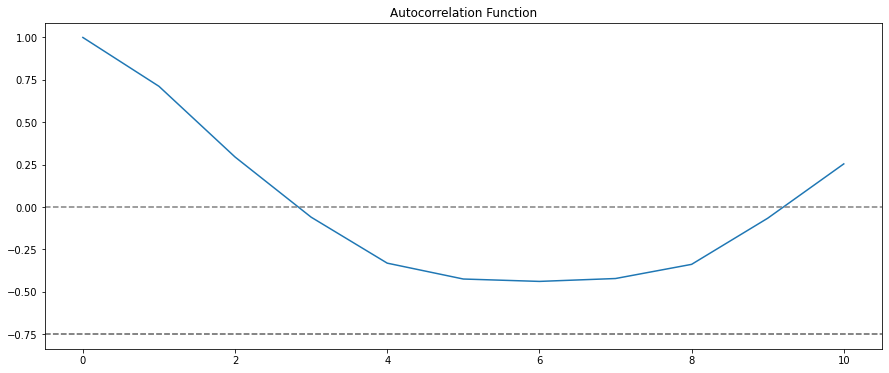

In [21]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()


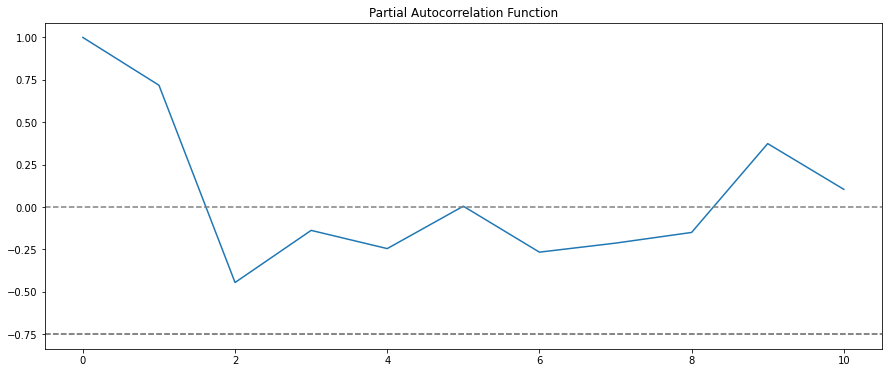

In [23]:
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

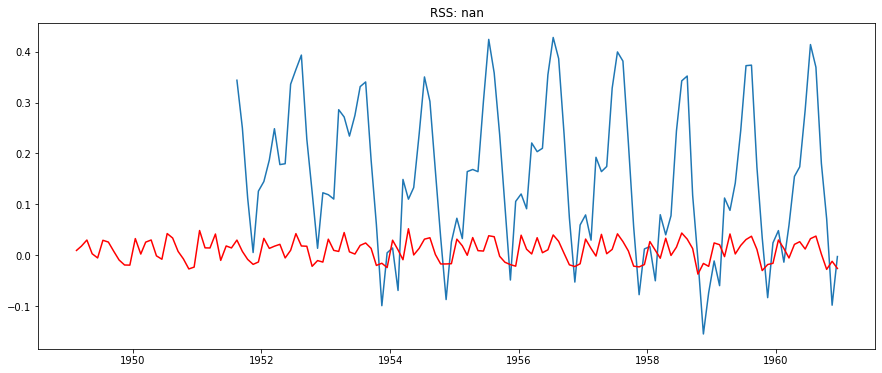

In [25]:
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [37]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

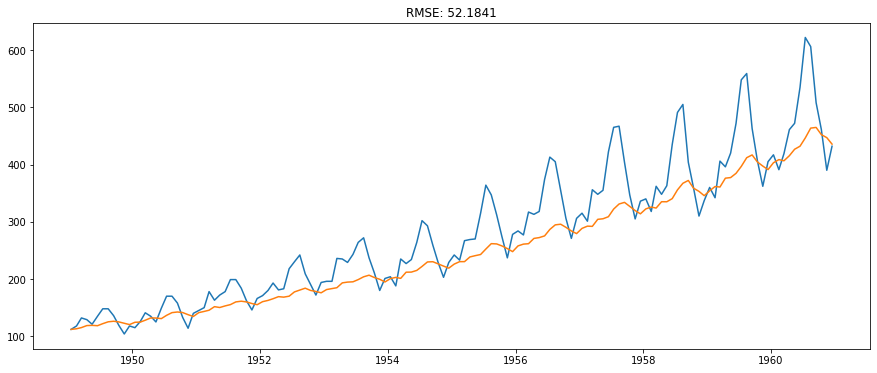

In [42]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
